# Binary Classification Model for [PROJECT NAME] Using Python and XGBoost version 2
### David Lowe
### October 7, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The data file patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.]

ANALYSIS: [Sample Paragraph - The performance of the preliminary XGBoost model achieved an accuracy benchmark of 81.94%. After a series of tuning trials, the best XGBoost model processed the training dataset with an accuracy score of 83.19%. When we applied the final model to the previously unseen test dataset, we obtained an accuracy score of 88.09%.]

CONCLUSION: [Sample Paragraph - In this iteration, XGBoost appeared to be a suitable algorithm for modeling this dataset. We should consider experimenting with XGBoost for further modeling.]

Dataset Used: [PROJECT NAME] Data Set

Dataset ML Model: Binary classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

One potential source of performance benchmark: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

Any predictive modeling machine learning project generally can be broken down into about five major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [62]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [63]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [64]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [65]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 'nproc' is not recognized as an internal or external command,


### 1.a) Load libraries and modules

In [66]:
# Set the random seed number for reproducible results
seedNum = 888

In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.feature_selection import RFE
# from imblearn.pipeline import Pipeline
# from imblearn.over_sampling import SMOTE
# from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier

### 1.b) Set up the controlling parameters and functions

In [68]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 2

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
# useColab = False
# if useColab:
#     # Mount Google Drive locally for storing files
#     from google.colab import drive
#     drive.mount('/content/gdrive')
#     gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
#     env_path = '/content/gdrive/My Drive/Colab Notebooks/'
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
# useLocalPC = False
# if useLocalPC:
#     env_path = "/Users/david/PycharmProjects/"
#     dotenv_path = env_path + "python_script.env"
#     load_dotenv(dotenv_path=dotenv_path)

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds for cross validation
n_folds = 5

# Set various default modeling parameters
scoring = 'accuracy'

In [69]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [70]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [71]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
attrNames = ['attr' + str(i).zfill(2) for i in range(1,61)]
colNames = attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
Xy_original.head()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [72]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [73]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [74]:
Xy_original.isnull().sum()

attr01    0
attr02    0
attr03    0
attr04    0
attr05    0
attr06    0
attr07    0
attr08    0
attr09    0
attr10    0
attr11    0
attr12    0
attr13    0
attr14    0
attr15    0
attr16    0
attr17    0
attr18    0
attr19    0
attr20    0
attr21    0
attr22    0
attr23    0
attr24    0
attr25    0
attr26    0
attr27    0
attr28    0
attr29    0
attr30    0
attr31    0
attr32    0
attr33    0
attr34    0
attr35    0
attr36    0
attr37    0
attr38    0
attr39    0
attr40    0
attr41    0
attr42    0
attr43    0
attr44    0
attr45    0
attr46    0
attr47    0
attr48    0
attr49    0
attr50    0
attr51    0
attr52    0
attr53    0
attr54    0
attr55    0
attr56    0
attr57    0
attr58    0
attr59    0
attr60    0
target    0
dtype: int64

In [75]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [76]:
# Standardize the class column to the name of targetVar if required
# Xy_original = Xy_original.rename(columns={'old_name': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Take a peek at the dataframe after cleaning
Xy_original.head()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [77]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [78]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [79]:
Xy_original.isnull().sum()

attr01    0
attr02    0
attr03    0
attr04    0
attr05    0
attr06    0
attr07    0
attr08    0
attr09    0
attr10    0
attr11    0
attr12    0
attr13    0
attr14    0
attr15    0
attr16    0
attr17    0
attr18    0
attr19    0
attr20    0
attr21    0
attr22    0
attr23    0
attr24    0
attr25    0
attr26    0
attr27    0
attr28    0
attr29    0
attr30    0
attr31    0
attr32    0
attr33    0
attr34    0
attr35    0
attr36    0
attr37    0
attr38    0
attr39    0
attr40    0
attr41    0
attr42    0
attr43    0
attr44    0
attr45    0
attr46    0
attr47    0
attr48    0
attr49    0
attr50    0
attr51    0
attr52    0
attr53    0
attr54    0
attr55    0
attr56    0
attr57    0
attr58    0
attr59    0
attr60    0
target    0
dtype: int64

In [80]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [81]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [82]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (208, 61) X_original.shape: (208, 60) y_original.shape: (208,)


In [83]:
# Split the data further into training and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (166, 60) y_train_df.shape: (166,)
X_test_df.shape: (42, 60) y_test_df.shape: (42,)


In [84]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [85]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [86]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

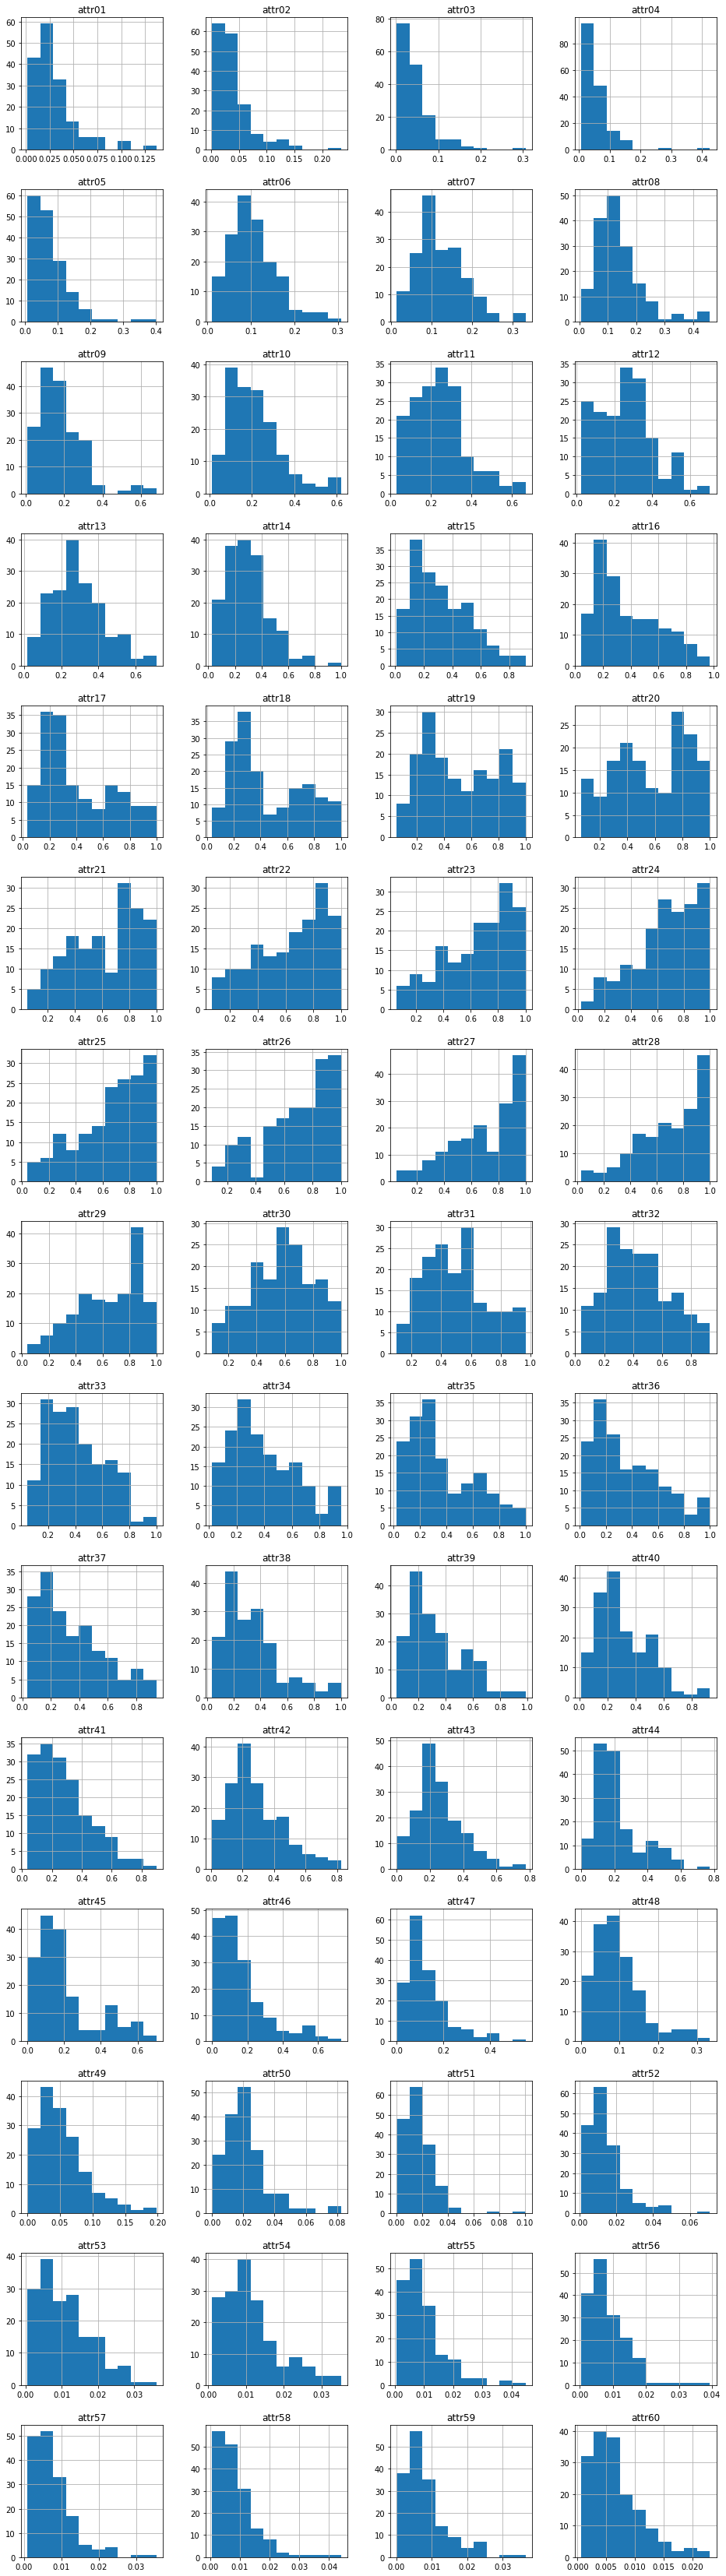

In [87]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

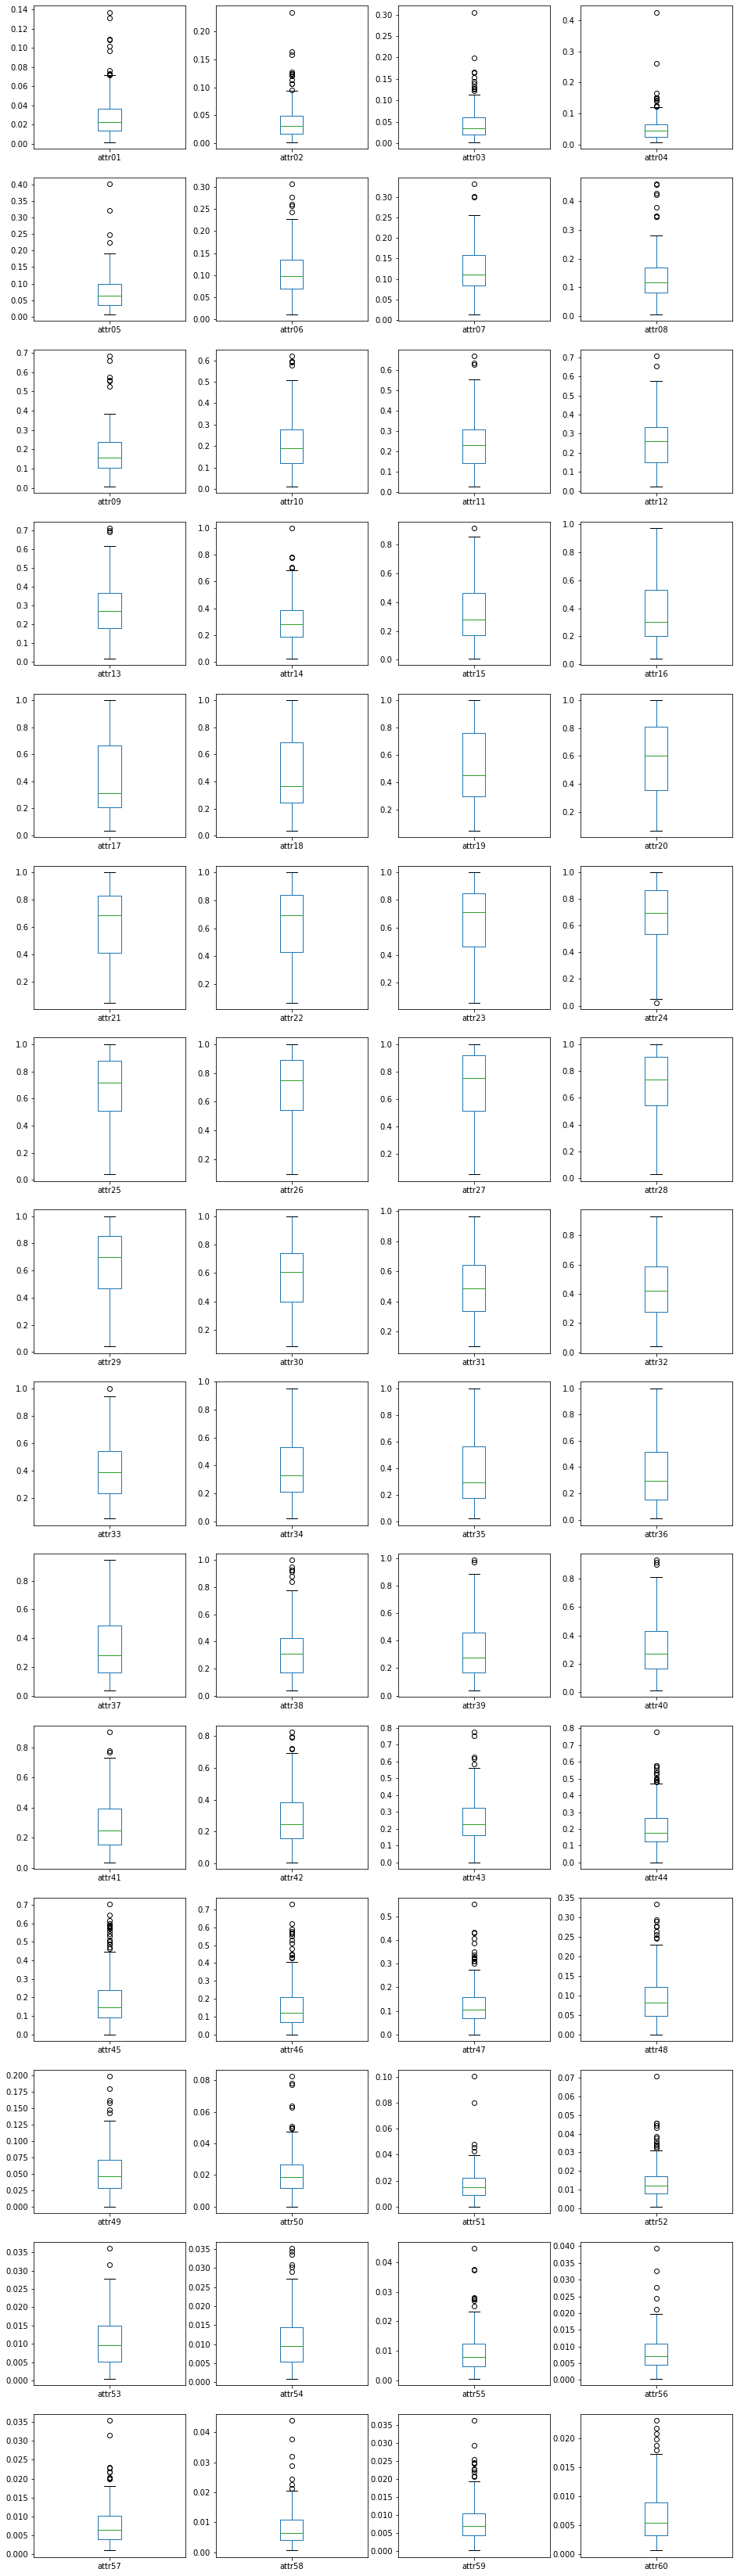

In [88]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

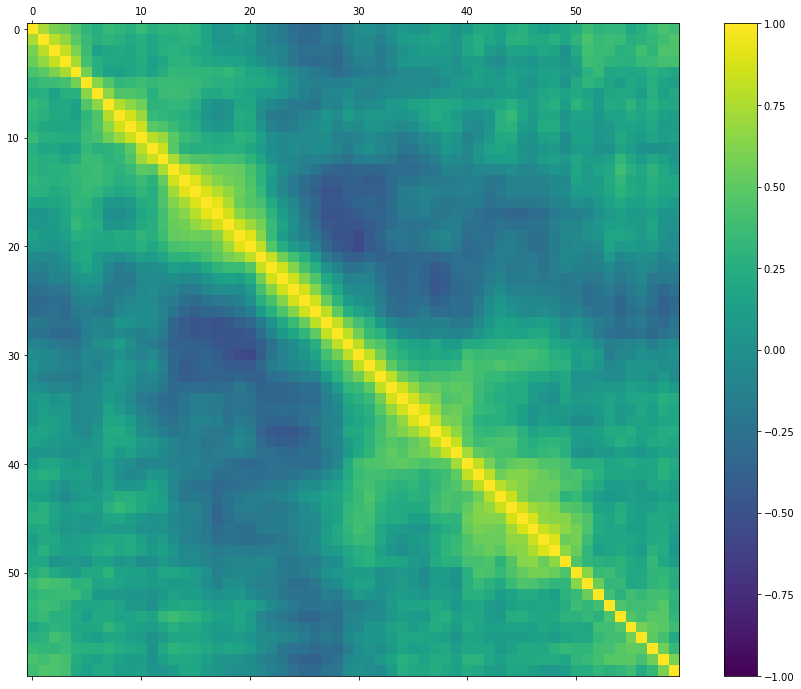

In [89]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [90]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [91]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [92]:
# Compose pipeline for the numerical and categorical features
numeric_columns = X_train_df.select_dtypes(include=['int','float']).columns
numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', preprocessing.StandardScaler())
])
categorical_columns = X_train_df.select_dtypes(include=['object','category']).columns
categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
    ('onehot', preprocessing.OneHotEncoder(sparse=False, handle_unknown='ignore'))
])

print("Number of numerical columns:", len(numeric_columns))
print("Number of categorical columns:", len(categorical_columns))
print("Total number of columns in the dataframe:", X_train_df.shape[1])

Number of numerical columns: 60
Number of categorical columns: 0
Total number of columns in the dataframe: 60


In [93]:
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_columns)
#     ('cat', categorical_transformer, categorical_columns)
])
X_train = preprocessor.fit_transform(X_train_df)
print("Transformed X_train.shape:", X_train.shape)

Transformed X_train.shape: (166, 60)


In [94]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train['new_feature1'] = feature_binned
# X_train['new_feature1'] = X_train['new_feature1'].astype('category')
# X_train.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train.head()

### 3.b) Training Data Balancing

In [95]:
# Not applicable for this iteration of the project

In [96]:
# Examine the target classes for imbalanced distribution
# Xy_original.groupby('targetVar').size()

In [97]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [98]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.c) Feature Selection

In [99]:
# Not applicable for this iteration of the project

In [100]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [101]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [102]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

In [103]:
# Perform Attribute Importance Ranking (Block #1 of 3)

# Feature Importance with Gradient Boosting Classifier
# X_impVal = X_train_df.values
# y_impVal = y_train_df.values.ravel()
# model = GradientBoostingClassifier(random_state=seedNum)
# model.fit(X_impVal, y_impVal)
# importanceScore = model.feature_importances_
# attributeList = X_train_df.columns.tolist()
# attributeImportance = pd.DataFrame({'attribute': attributeList, 'importance': importanceScore})
# rankedAttributes = attributeImportance.sort_values('importance', ascending=False)
# print(rankedAttributes)

In [104]:
# Perform Attribute Importance Ranking (Block #2 of 3)

# Set the importance threshold and calculate the list of attributes that don't contribute to the importance threshold
# importanceSum = sum(importanceScore)
# maxThreshold = 0.99
# i = 0
# accumWeight = 0
# exit_now = False
# while ((i < totAttr) and (not exit_now)) :
#     accumWeight = accumWeight + (rankedAttributes.iloc[i]['importance']/importanceSum)
#     if (accumWeight >= maxThreshold) :
#         exit_now = True
#     else :
#         i = i + 1
# print('Number of attributes contributed to the importance threshold:'+str(i))
# lowAttributes = rankedAttributes.iloc[(i):(totAttr),]['attribute'].tolist()
# print('Number of attributes found to be of low importance:',len(lowAttributes))
# print(lowAttributes)

In [105]:
# Perform Attribute Importance Ranking (Block #3 of 3)

# Removing the unselected attributes from the training and validation dataframes
# X_train_df.drop(labels=lowAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=lowAttributes, axis=1, inplace=True)

In [106]:
# Perform Recursive Feature Elimination (Block #1 of 3)

# Using the ensemlbed tree algorithm, we perform the Recursive Feature Elimination (RFE) technique
# X_rfeVal = X_train_df.values
# y_rfeVal = y_train_df.values.ravel()
# estFunc = ExtraTreesClassifier(random_state=seedNum, n_jobs=cpu_num)
# strFold = StratifiedKFold(n_splits=num_folds, random_state=seedNum)
# minFeatures = 10
# selector = RFECV(estimator=estFunc, step=1, min_features_to_select= minFeatures, cv=strFold, scoring=scoring)
# selector = selector.fit(X_rfeVal, y_rfeVal)
# print('The number of selected features:',selector.n_features_)
# print('The mask of selected features:\n',selector.support_)
# print('The ranking of selected features:\n',selector.ranking_)
# plt.figure(figsize=(16,12))
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score")
# plt.plot(range(minFeatures, len(selector.grid_scores_) + minFeatures), selector.grid_scores_)
# plt.show()

In [107]:
# Perform Recursive Feature Elimination (Block #2 of 3)

# Remove the unselected attributes from the training dataframes
# X_train_df = X_train_df[X_train_df.columns[selector.support_]]
# print(X_train_df.shape)
# X_train_df.head()

In [108]:
# Perform Recursive Feature Elimination (Block #3 of 3)

# Remove the unselected attributes from the validation dataframes
# X_test_df = X_test_df[X_test_df.columns[selector.support_]]
# print(X_test_df.shape)
# X_test_df.head()

### 3.d) Display the Final Datasets for Model-Building

In [109]:
# Finalize the training dataset for the modeling activities
class_encoder = preprocessing.LabelEncoder()
y_train = class_encoder.fit_transform(y_train_df)
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (166, 60) y_train.shape: (166,)


In [110]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [111]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 4.a) Set test options and evaluation metric

In [112]:
# Set up Algorithms Spot-Checking Array
startTimeModule = datetime.now()
train_models = [('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic'))]
# train_models.append(('XGB', XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')))

In [113]:
# Generate model in turn
for name, model in train_models:
	if notifyStatus: status_notify("Algorithm "+name+" modeling has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))
	startTimeModule = datetime.now()
	kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring, n_jobs=n_jobs, verbose=1)
	print("%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))
	print(model)
	print ('Model training time:', (datetime.now() - startTimeModule), '\n')
	if notifyStatus: status_notify("Algorithm "+name+" modeling completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

XGB: 0.819430 (0.042038)
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=2, num_parallel_tree=None,
              random_state=888, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)
Model training time: 0:00:00.088020 

Average metrics (accuracy) from all models: 0.8194295900178254
Total training time for all models: 0:00:00.106024


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:    0.0s finished


### 4.b) Algorithm Tuning

In [114]:
# Set up the comparison array
tune_results = []
tune_model_names = []

In [115]:
# Tuning XGBoost n_estimators, max_depth, and min_child_weight parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #1 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model1 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic')
# tune_model1 = XGBClassifier(random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_1')
paramGrid1 = dict(n_estimators=range(100,501,100), max_depth=np.array([3,6,9]), min_child_weight=np.array([1,2,3]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid1 = GridSearchCV(estimator=tune_model1, param_grid=paramGrid1, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result1 = grid1.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result1.best_score_, grid_result1.best_params_))
tune_results.append(grid_result1.cv_results_['mean_test_score'])
means = grid_result1.cv_results_['mean_test_score']
stds = grid_result1.cv_results_['std_test_score']
params = grid_result1.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #1 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done 164 tasks      | elapsed:    2.7s
[Parallel(n_jobs=2)]: Done 225 out of 225 | elapsed:    3.7s finished


Fitting 5 folds for each of 45 candidates, totalling 225 fits
Best: 0.831907 using {'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200}
0.819608 (0.040888) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100}
0.825668 (0.037870) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 200}
0.825668 (0.037870) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 300}
0.825668 (0.037870) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 400}
0.825668 (0.037870) with: {'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 500}
0.819786 (0.054994) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100}
0.825847 (0.056142) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 200}
0.825847 (0.056142) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 300}
0.825847 (0.056142) with: {'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 400}
0.825847 (0.056142) with: {'max_depth': 3, 'min_child_weight': 2, 'n_esti

In [116]:
# Tuning XGBoost subsample and colsample_bytree parameters
startTimeModule = datetime.now()
if notifyStatus: status_notify("Algorithm tuning iteration #2 has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

tune_model2 = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic')
# tune_model2 = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
tune_model_names.append('XGB_2')
paramGrid2 = dict(subsample=np.array([0.7,0.8,0.9,1.0]), colsample_bytree=np.array([0.7,0.8,0.9,1.0]))

kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=seedNum)
grid2 = GridSearchCV(estimator=tune_model2, param_grid=paramGrid2, scoring=scoring, cv=kfold, n_jobs=n_jobs, verbose=1)
grid_result2 = grid2.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
tune_results.append(grid_result2.cv_results_['mean_test_score'])
means = grid_result2.cv_results_['mean_test_score']
stds = grid_result2.cv_results_['std_test_score']
params = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print ('Model training time:',(datetime.now() - startTimeModule))
if notifyStatus: status_notify("Algorithm tuning iteration #2 completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  80 out of  80 | elapsed:    0.9s finished


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best: 0.831907 using {'colsample_bytree': 0.9, 'subsample': 1.0}
0.807487 (0.047897) with: {'colsample_bytree': 0.7, 'subsample': 0.7}
0.813369 (0.021447) with: {'colsample_bytree': 0.7, 'subsample': 0.8}
0.807487 (0.055034) with: {'colsample_bytree': 0.7, 'subsample': 0.9}
0.783601 (0.049278) with: {'colsample_bytree': 0.7, 'subsample': 1.0}
0.807665 (0.068941) with: {'colsample_bytree': 0.8, 'subsample': 0.7}
0.777184 (0.048791) with: {'colsample_bytree': 0.8, 'subsample': 0.8}
0.765419 (0.059959) with: {'colsample_bytree': 0.8, 'subsample': 0.9}
0.771480 (0.042548) with: {'colsample_bytree': 0.8, 'subsample': 1.0}
0.789661 (0.057980) with: {'colsample_bytree': 0.9, 'subsample': 0.7}
0.783779 (0.081790) with: {'colsample_bytree': 0.9, 'subsample': 0.8}
0.807843 (0.056125) with: {'colsample_bytree': 0.9, 'subsample': 0.9}
0.831907 (0.059776) with: {'colsample_bytree': 0.9, 'subsample': 1.0}
0.813904 (0.061559) with: {'colsam

### 4.c) Compare Models After Tuning

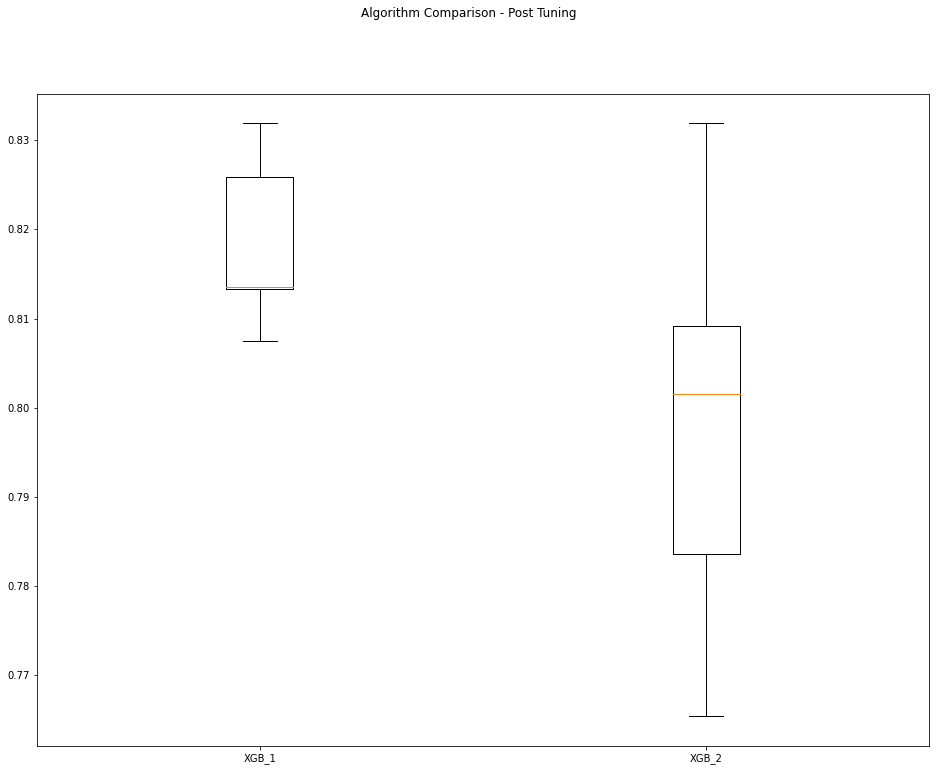

In [117]:
fig = plt.figure(figsize=(16,12))
fig.suptitle('Algorithm Comparison - Post Tuning')
ax = fig.add_subplot(111)
plt.boxplot(tune_results)
ax.set_xticklabels(tune_model_names)
plt.show()

In [118]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [119]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [120]:
# Apply the same data preparation steps to the test dataset
X_test = preprocessor.transform(X_test_df)
# Encode the target variable
y_test = class_encoder.transform(y_test_df)
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (42, 60) y_test.shape: (42,)


In [121]:
test_model = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, colsample_bytree=0.9, subsample=1.0, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic')
# test_model = XGBClassifier(n_estimators=200, max_depth=6, min_child_weight=2, colsample_bytree=0.9, subsample=1.0, random_state=seedNum, n_jobs=n_jobs, objective='binary:logistic', tree_method='gpu_hist')
test_model.fit(X_train, y_train)
print(test_model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=2, num_parallel_tree=1, random_state=888,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [122]:
test_predictions = test_model.predict(X_test)
print('Accuracy Score:', accuracy_score(y_test, test_predictions))
print('ROC/AUC Score:', roc_auc_score(y_test, test_predictions))
print(confusion_matrix(y_test, test_predictions))
print(classification_report(y_test, test_predictions))

Accuracy Score: 0.8809523809523809
ROC/AUC Score: 0.862962962962963
[[12  3]
 [ 2 25]]
              precision    recall  f1-score   support

           0       0.86      0.80      0.83        15
           1       0.89      0.93      0.91        27

    accuracy                           0.88        42
   macro avg       0.88      0.86      0.87        42
weighted avg       0.88      0.88      0.88        42



In [123]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [124]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:00:13.970166
